In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import dash
import dash_bootstrap_components as dbc
from dash import dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

/var/folders/mc/sd8lk0kn4fz1q41w5qdn2fhc0000gn/T/ipykernel_8140/3440974946.py:11: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


## Introduction

Here we will compute the basic formulae for options in __Black and Scholes model.__

One of the assumptions of the model is that the considered stock follows a Geometric Brownian motion. It incorporates two key components: the drift ($\mu$) and the volatility ($\sigma$). The drift represents the expected return of the stock, while the volatility measures the standard deviation of the returns. This model assumes continuous evolution of the stock price over time.

Stocks dynamics are described by the following equation: 

$$dS_t = \mu S_t dt  + \sigma S_t dW_t$$

- $dS_t$ represents the change in the stock price at time $t$.
- $\mu S_t$ captures the expected growth of the stock.
- $\sigma S_t dW_t$represents the random component due to the Brownian motion (Wiener process)
- $dt$ denotes a small change in time.
- $dW$ is a random variable with mean zero and variance $dt$.


Under this model, and using the assumption that there is no arbitrage opportunity, the value at $t$ of an european call option with strike $K$, maturity $T$ and constant risk-free rate $r$ is given by the formula:

$$V_t = S_t N(d_1) - Ke^{-r(T-t)}N(d_2)$$

The function $N(x)$ represents the cumulative distribution function for the standarized normal distribution. 

where
$$d_1 = \frac{log(\frac{S}{K}) + (r + \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T - t}}$$

and
$$d_1 = \frac{log(\frac{S}{K}) + (r - \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T - t}}$$


*For the put value we will use the call-put parity.*

Thus, __in Black-Scholes model there exist an explicit function for european vanilla options, this is not the case for american ones or for more exotic options.__

## Delta

The delta of an option or a portfolio ofoptions is the __sensitivity of the option/portfolio to the underlying asset.__

It is the rate of change of value with respect to the asset: 

$$\Delta = \frac{\partial V}{\partial S}$$

As the Delta is a partial derivative (linear functional), the delta of a portfolio of options on the same underlying is just the sum of the deltas of all te individuals positions.$

Just as European-style options have an explicit formula in the Black-Scholes model, the delta of European call and put also have an explicit formula.

For a call:

$$\Delta_C = N(d_1)$$

For a put: 

$$\Delta_P = N(d_1) - 1$$

## Gamma

Gamma ($\Gamma$) is a __measure of the rate of change of an option's or a portfolio of options' delta with respect to the underlying asset's price__.

In simpler terms, it quantifies how quickly the delta of an option or portfolio changes in response to small movements in the price of the underlying asset.

Gamma is important because it helps assess the potential for delta changes and the associated risk of the option or portfolio. Higher gamma values indicate greater sensitivity to price movements, while lower gamma values indicate less sensitivity.

For european call and puts we have same gamma:

$$\Gamma = \frac{N'(d_1)}{S_t \sqrt{T - t}}$$

## Theta

Theta ($\Theta$) is the __rate of change of the option price with time.__

We have to understand that the theta of an option contributes in a completely certain way, unlike delta or gamma, as the passage of time is something deterministic, not as the fluctuations of the underlying asset price which is completely random. 

For an european call: 

$$\Theta_c = - \frac{\sigma S_t N'(d_1)}{2\sqrt{T - t}} - rKe^{-r(T - t)}N(d_2)$$

For the corresponding put: 

$$\Theta_p = - \frac{\sigma S_t N'( - d_1)}{2\sqrt{T - t}} + rKe^{-r(T - t)}N(-d_2)$$

In [2]:
def norm_cdf(x):
    """
    Computing the cumulative distribution function for a standard normal random variable.
    
    """
    return (1 + math.erf(x / math.sqrt(2))) / 2

def norm_pdf(x): 
    """
    Computing the probability density function for a standard normal random variable.
    
    """
    return math.exp(-x**2 / 2) / math.sqrt(2 * math.pi)

In [3]:
def euro_values(S0, K, r, sigma, T, D=0):
    # Computing d1 and d2 as defined before
    d1 = (math.log(S0 / K) + (r - D + sigma**2 / 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    # Computing european call price
    call_price = S0 * math.exp(-D * T) * norm_cdf(d1) - K * math.exp(-r * T) * norm_cdf(d2)

    # Computing put price using call-put parity
    put_price = call_price - S0 * math.exp(-D * T) + K * math.exp(-r * T)

    # Call Greeks
    call_delta = math.exp(-D * T) * norm_cdf(d1)
    call_gamma = (math.exp(-D * T) * norm_pdf(d1)) / (S0 * sigma * math.sqrt(T))
    call_theta = (-S0 * math.exp(-D * T) * norm_pdf(d1) * sigma) / (2 * math.sqrt(T)) - r * K * math.exp(-r * T) * norm_cdf(d2) + D * S0 * math.exp(-D * T) * norm_cdf(d1)
    call_vega = S0 * math.exp(-D * T) * norm_pdf(d1) * math.sqrt(T)
    call_rho = K * T * math.exp(-r * T) * norm_cdf(d2)

    # Put Greeks (also computed using call-put parity)
    put_delta = call_delta - math.exp(-D * T)
    put_gamma = call_gamma
    put_theta = call_theta + D * S0 * math.exp(-D * T) - r * K * math.exp(-r * T)
    put_vega = call_vega
    put_rho = -K * T * math.exp(-r * T) * norm_cdf(-d2)

    return call_price, put_price, call_delta, call_gamma, call_theta, call_vega, call_rho, put_delta, put_gamma, put_theta, put_vega, put_rho


In [4]:
def calculate_option_values(stock_price, strike_price, time_to_maturity, option_type):
    
    """
    Computing option greeks and values in order to plot it in our application
    
    """
    
    #Desired stock prices. 
    stock_prices = np.linspace(0.1, 2 * stock_price, 100)
    
    #Empty lists where we are going to put computed values
    option_values_stock = []
    time_to_maturities = np.linspace(0.01, 5, 100)
    option_values_time = []
    option_deltas = []
    option_gammas = []
    option_thetas = []
    for price in stock_prices:
        call_price, put_price, call_delta, call_gamma, call_theta, call_vega, call_rho, put_delta, put_gamma, put_theta, put_vega, put_rho = euro_values(
            price, strike_price, 0.05, 0.2, time_to_maturity)
        if option_type == "call":
            option_values_stock.append(call_price)
            option_deltas.append(call_delta)
            option_gammas.append(call_gamma)
            option_thetas.append(call_theta)
        else:
            option_values_stock.append(put_price)
            option_deltas.append(put_delta)
            option_gammas.append(put_gamma)
            option_thetas.append(put_theta)
    for ttm in time_to_maturities:
        call_price, put_price, _, _, _, _, _, _, _, _, _, _ = euro_values(
            stock_price, strike_price, 0.05, 0.2, ttm)
        if option_type == "call":
            option_values_time.append(call_price)
        else:
            option_values_time.append(put_price)
    return stock_prices, option_values_stock, time_to_maturities, option_values_time, option_deltas, option_gammas, option_thetas

In [5]:
def black_scholes_call_price(strike, volatility, underlying_price, risk_free_rate, maturity):
    d1 = (np.log(underlying_price / strike) + (risk_free_rate + 0.5 * volatility**2) * maturity) / (volatility * np.sqrt(maturity))
    d2 = d1 - volatility * np.sqrt(maturity)
    call_price = underlying_price * norm.cdf(d1) - strike * np.exp(-risk_free_rate * maturity) * norm.cdf(d2)
    return call_price

def volatility_smile(strikes, atm_vol, smile_curvature):
    volatilities = []
    for K in strikes:
        moneyness = np.log(K / atm_strike)
        volatility = atm_vol + smile_curvature * moneyness**2
        volatilities.append(volatility)
    return volatilities



def approximate_second_derivative(strikes, volatilities, underlying_price, risk_free_rate, maturity):
    eps = 0.01  # Little perturbation to compute finite difference
    second_derivatives = []
    for i in range(len(strikes)):
        strike = strikes[i]
        volatility = volatilities[i]

        call_price_plus = black_scholes_call_price(strike + eps, volatility, underlying_price, risk_free_rate, maturity)
        call_price_minus = black_scholes_call_price(strike - eps, volatility, underlying_price, risk_free_rate, maturity)
        call_price = black_scholes_call_price(strike, volatility, underlying_price, risk_free_rate, maturity)

        second_derivative = math.exp(risk_free_rate * maturity)*(call_price_plus - 2 * call_price + call_price_minus) / (eps**2)
        second_derivatives.append(second_derivative)
    return second_derivatives

# Ejemplo de uso
atm_strike = 100  # Precio de ejercicio del dinero
atm_vol = 0.2  # Volatilidad implícita en el dinero
smile_curvature = 0.6  # Curvatura de la curva de sonrisa de volatilidad
strikes = np.linspace(80, 120, 100)  # Precios de ejercicio
T = 1.0  # Vencimiento en años

volatilities = volatility_smile(strikes, atm_vol, smile_curvature)

approximate_second_derivative(strikes, volatilities, atm_strike,0.03, T)

[0.013338188483098588,
 0.013545375922680018,
 0.013754767230032175,
 0.013966125178192372,
 0.014179195846448675,
 0.014393712720559053,
 0.014609392153223037,
 0.014825936585682487,
 0.015043035133467147,
 0.015260361389848718,
 0.01547757708675076,
 0.01569433165543951,
 0.01591026193365109,
 0.016124995387192222,
 0.01633814820626709,
 0.01654933028431482,
 0.016758141996408737,
 0.016964178958439283,
 0.01716703151458662,
 0.017366287666048554,
 0.01756153358356794,
 0.01775235492536024,
 0.01793834013193246,
 0.018119079986773933,
 0.018294171350484483,
 0.018463217600083577,
 0.018625830239810695,
 0.018781632415598864,
 0.01893025854898366,
 0.019071357046176535,
 0.019204592274956203,
 0.01932964485754139,
 0.019446215111846212,
 0.01955402107458876,
 0.019652805530238186,
 0.019742331325049992,
 0.019822384515448568,
 0.019892777223536905,
 0.01995334639238725,
 0.020003955103968674,
 0.020044491188001272,
 0.020074872274011887,
 0.020095040958933004,
 0.020104967955485283,
 

[0.008221365980313589, 0.008497717284312648, 0.008797842910117839, 0.00912274320402546, 0.009473435207179274, 0.009850940106423421, 0.01025627075985263, 0.010690414441734988, 0.011154317156078071, 0.011648861526226944, 0.012174847933794869, 0.012732969046882623, 0.01332378591694118, 0.01394770127448552, 0.014604931330862304, 0.015295478102898753, 0.016019100990578405, 0.01677528794388176, 0.017563229244032547, 0.01838179195701972, 0.01922949789789274, 0.020104504433554462, 0.0210045899167868, 0.021927143452720097, 0.022869162508519367, 0.023827255229000747, 0.024797649699097184, 0.025776215083195515, 0.026758482465684266, 0.02773968279718417, 0.02871478431789749, 0.029678543725261325, 0.030625559507822718, 0.031550332823541485, 0.032447333233417835, 0.03331106615315792, 0.034136142993942374, 0.034917352610397724, 0.03564973032090529, 0.03632862281955848, 0.03694975241584429, 0.03750927119018877, 0.03800381167607783, 0.038430527420693375, 0.038787125030056754, 0.0390718875866336, 0.0392

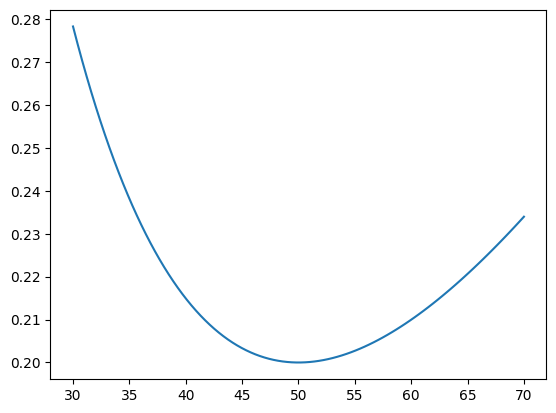

In [6]:
atm_strike = 50 
strikes = np.linspace(atm_strike - 20, atm_strike + 20, 100)
volatilities = volatility_smile(strikes, 0.2, 0.3)
sec_der = approximate_second_derivative(strikes, volatilities, atm_strike, 0.05, T)
plt.plot(strikes, volatilities)
print(sec_der)

In [7]:
# Defining the app.  
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.LUX])

# Defining app layout
app.layout = dbc.Container(
    [
        html.H1("European Options Dashboard under Black and Scholes model", className="mt-5"),
        html.Hr(),
        html.H2("Parameters"),
        dbc.Row(
            [
                dbc.Col(
                    [
                        html.Label("Time to Maturity: "),
                        dcc.Slider(id="time-slider",min=0,max=5,step=0.1,value=2,marks={0: "0",1: "1",2: "2",3: "3",4: "4",5: "5"},),
                    ],
                    className="mt-3",
                ),
                dbc.Col(
                    [
                        html.Label("Strike Price: "),
                        dcc.Input(id="strike-input", type="number", value=50),
                    ],
                    className="mt-3",
                ),
                dbc.Col(
                    [
                        html.Label("Stock Price: "),
                        dcc.Input(id="stock-input", type="number", value=50, style={"margin-right": "10px"}),
                        
                    ],
                    className="mt-3",
                ),
                dbc.Col(
                    [
                        dcc.Dropdown(

                            id="option-type-dropdown",
                            options=[
                                {"label": "Call", "value": "call"},
                                {"label": "Put", "value": "put"},
    ],
    value="call",
),
                    ],
                    className="mt-3",
                ),
            ]
        ),
        html.Hr(),
        html.H2("Options Value"),
        dbc.Row(
            [
                dbc.Col(
                    dcc.Graph(id="stock-value-graph"),
                    width=6,
                    className="mt-3",
                ),
                dbc.Col(
                    dcc.Graph(id="time-value-graph"),
                    width=6,
                    className="mt-3",
                ),
            ]
        ),
    html.Hr(),
        html.H2("Greeks"),
        dbc.Row(
            [
                dbc.Col(
                    dcc.Graph(id="delta-graph"),
                    width=4,
                    className="mt-3",
                ),
                dbc.Col(
                    dcc.Graph(id="gamma-graph"),
                    width=4,
                    className="mt-3",
                ),
                                dbc.Col(
                    dcc.Graph(id="theta-graph"),
                    width=4,
                    className="mt-3",
                )
            ]
        ),
    html.Hr(),
        html.H2("Volatility"),
        dbc.Row(
            [
                dbc.Col(
                    dcc.Graph(id="smile-graph"),
                    width=6,
                    className="mt-3",
                ),
                dbc.Col(
                    dcc.Graph(id="cdf-graph"),
                    width=6,
                    className="mt-3",
                )
            ]
        )
    ],
    fluid=True
)


# Defining the function that is going to be called back once paramaters are modified. 
@app.callback(
    [dash.dependencies.Output("stock-value-graph", "figure"),
     dash.dependencies.Output("time-value-graph", "figure"),
     dash.dependencies.Output("delta-graph", "figure"),
     dash.dependencies.Output("gamma-graph", "figure"),
     dash.dependencies.Output("theta-graph", "figure"),
     dash.dependencies.Output("smile-graph", "figure"),
     dash.dependencies.Output("cdf-graph", "figure")
    ],
    [dash.dependencies.Input("time-slider", "value"),
     dash.dependencies.Input("strike-input", "value"),
     dash.dependencies.Input("stock-input", "value"),
     dash.dependencies.Input("option-type-dropdown", "value")]
)
def update_options_value_graph(time_to_maturity, strike_price, stock_price, option_type):
    
    
    stock_prices, option_values_stock, time_to_maturities, option_values_time, option_deltas, option_gammas, option_thetas = calculate_option_values(
        stock_price, strike_price, time_to_maturity, option_type)
    
    if option_type == "call":
        current_value = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[0]
        current_delta = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[2]
        current_gamma = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[3]
        current_theta = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[4]
    else:
        current_value = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[1]
        current_delta = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[7]
        current_gamma = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[8]
        current_theta = euro_values(stock_price, strike_price, 0.05, 0.2, time_to_maturity)[9]
        

        
    fig_stock = {
        "data": [
            {
                "x": stock_prices,
                "y": option_values_stock,
                "mode": "lines",
                "name": "Option Value", 
                "line": {"color": "rgb(0, 0, 255)"}
            },
            {
                "x": [stock_price],
                "y": [current_value],
                "mode": "markers",
                "marker": {"size": 10},
                "name": "Current Stock Price"
            }
        ],
        "layout": {
            "title": " Value vs. Stock Price",
            "xaxis": {"title": "Stock Price", "showgrid": False},
            "yaxis": {"title": "Option Value", "showgrid": False} 
            
        }
    }
    
    fig_time = {
        "data": [
            {
                "x": time_to_maturities,
                "y": option_values_time,
                "mode": "lines",
                "name": "Option Value", 
                "line": {"color": "rgb(0, 0, 255)"}
            },
            {
                "x": [time_to_maturity],
                "y": [current_value],
                "mode": "markers",
                "marker": {"size": 10},
                "name": "Current Time to Maturity"
            }
        ],
        "layout": {
            "title": "Value vs. Time to Maturity",
            "xaxis": {"title": "Time to Maturity (in Yrs.)", "showgrid": False},
            "yaxis": {"title": "Option Value", "showgrid": False}
            
        }
    }
    
    fig_delta = {
        "data": [
            {
                "x": stock_prices,
                "y": option_deltas,
                "mode": "lines",
                "name": "Delta", 
                "line": {"color": "rgb(0, 0, 255)"}
            },
            {
                "x": [stock_price],
                "y": [current_delta],
                "mode": "markers",
                "marker": {"size": 10},
                "name": "Current Delta"
            }
        ],
        "layout": {
            "title": " Delta vs. Stock Price",
            "xaxis": {"title": "Stock Price", "showgrid": False},
            "yaxis": {"title": "Delta", "showgrid": False}, 
            
        }
    }
    fig_gamma = {
        "data": [
            {
                "x": stock_prices,
                "y": option_gammas,
                "mode": "lines",
                "name": "Delta", 
                "line": {"color": "rgb(0, 0, 255)"}
            },
            {
                "x": [stock_price],
                "y": [current_gamma],
                "mode": "markers",
                "marker": {"size": 10},
                "name": "Current Gamma"
            }
        ],
        "layout": {
            "title": "Gamma vs. Stock Price",
            "xaxis": {"title": "Stock Price", "showgrid": False},
            "yaxis": {"title": "Gamma", "showgrid": False}, 
            
        }
    }
    fig_theta = {
        "data": [
            {
                "x": stock_prices,
                "y": option_thetas,
                "mode": "lines",
                "name": "Theta", 
                "line": {"color": "rgb(0, 0, 255)"}
            },
            {
                "x": [stock_price],
                "y": [current_theta],
                "mode": "markers",
                "marker": {"size": 10},
                "name": "Current Theta"
            }
        ],
        "layout": {
            "title": "Theta vs. Stock Price",
            "xaxis": {"title": "Stock Price", "showgrid": False},
            "yaxis": {"title": "Theta", "showgrid": False}
            
        }
    }
    # Modeling Vol. Smiles and Implied cdf.
    
    atm_strike = strike_price 
    strikes = np.linspace(atm_strike - 20, atm_strike + 20, 100)
    T = time_to_maturity
    volatilities = volatility_smile(strikes, 0.2, 0.3)
    sec_der = approximate_second_derivative(strikes, volatilities, atm_strike, 0.05, T)
    fig_vol = {
        "data": [
            {
                "x": strikes,
                "y": volatilities,
                "mode": "lines",
                "name": "Vol. Smile", 
                "line": {"color": "rgb(0, 0, 255)"}
            }
        ],
        "layout": {
            "title": "Volatility Smile",
            "xaxis": {"title": "Strike", "showgrid": False},
            "yaxis": {"title": "I. Vol", "showgrid": False}
            
        }
    }
    fig_cdf = {
        "data": [
            {
                "x": strikes,
                "y": sec_der,
                "mode": "lines",
                "name": "Empirical cdf", 
                "line": {"color": "rgb(0, 0, 255)"}
            }
        ],
        "layout": {
            "title": "Implied Probability Distribution",
            "xaxis": {"title": "Stock Price", "showgrid": False},
            "yaxis": {"title": "Probability", "showgrid": False}
            
        }
    }
    
    return fig_stock, fig_time, fig_delta, fig_gamma, fig_theta, fig_vol, fig_cdf

# Executing the app.
if __name__ == "__main__":
    app.run_server(debug=False)


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET /_favicon.ico?v=2.10.2 HTTP/1.1" 200 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET /_dash-component-suites/dash/dcc/async-slider.js HTTP/1.1" 304 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [07/Jun/2023 15:26:47] "POST /_dash-update-component HTTP/1.1" 200 -


## Application Use

The application we created, "European Options Dashboard under Black and Scholes model," could be useful for a portfolio manager in several aspects:

- <u>Options analysis:</u> The application allows for calculating the value of European options and related metrics (such as the Greek letters) using the Black and Scholes model. This is helpful in evaluating different options strategies and understanding the impact of various parameters on options value.

- <u>Decision-making:</u> By providing an interactive visualization of options values based on key parameters like time to maturity, strike price, and current stock price, the application enables the portfolio manager to quickly evaluate different scenarios and make informed decisions regarding options buying or selling.

- <u>Market monitoring:</u> With the ability to adjust parameters in real-time, such as the current stock price, the portfolio manager can use the application to monitor and track options values based on market changes. This facilitates tracking of existing options strategies and identification of adjustment or rebalancing opportunities for the portfolio.

- <u>Reporting:</u> The application offers clear graphical visualization of options values based on selected parameters. This can be used by the portfolio manager to generate reports and visual presentations for investors or to support strategic decision-making within the company.

In summary, the application allows the portfolio manager to evaluate and analyze options, make informed decisions, monitor the market, and generate visual reports. All of these contribute to enhancing options management and optimizing the investment portfolio.